In [1]:
# Try to get something out of pyshark. Forked from the notebook attached 
# to JC's paper (paper_80211_analysis.ipynb)

# SEE FURTHER: bitflip_poscount_onthefly.ipynb 

In [2]:
import os
#import mypyshark as pyshark # modified version to support tcpdump -C (wireshark profile selection..)
import pyshark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# https://stackoverflow.com/a/8898977
def bits(n):
    while n:
        b = n & (~n+1)
        yield b
        n ^= b

def getposb1(hex_value):
    return np.array([pos for pos, char in enumerate(bin(hex_value)[2:]) if char == "1"]) # not as generator

# some constants
AP_MAC = 'e0:89:9d:70:11:0d' # eduroam AP in student room FAL108
NEXUS5X_MAC = '64:bc:0c:9d:89:1e'
TP470_MAC = '9c:da:3e:68:6a:fa'

In [7]:
def load_capture(filename, flt=''):
    print("[Pyshark] Opening {} with display_filter='{}'".format(filename,flt))
    #cap = pyshark.FileCapture(filename, display_filter=flt, configuration_profile='udp_only') # needs Pyshark hack!
    cap = pyshark.FileCapture(filename, display_filter=flt)
    
    cap.set_debug()

    d_rssi, d_data_rate, d_tx_mac, d_time_rel, d_badfcs, d_datalen, d_data, d_datacountb1, d_dataposb1 = \
        [], [], [], [], [], [], [], [], []

    limit = 0 # 0=no limit
    for pkt in cap:
        #print("processing packet at time" + pkt.frame_info.time_relative)
        #pprint(dir(pkt.radiotap))
        #if pkt.radiotap.flags_badfcs == '1':
        #pprint(dir(pkt))
        try:
            time_rel = float(pkt.frame_info.time_relative)
            #rssi = int(pkt.radiotap.dbm_antsignal)
            rssi = 0
            #data_rate = float(pkt.radiotap.datarate.replace(',','.'))
            data_rate = 0
            #badfcs = int(pkt.radiotap.flags_badfcs)
            badfcs = False
            datalen = int(pkt.data.len)
            #data = pkt.data.data.hex_value
            datacountb1 = bin(pkt.data.data.hex_value).count("1")
            dataposb1 = getposb1(pkt.data.data.hex_value)
        except AttributeError as e: 
            print("caught AttributeError: {} (continuing)".format(e))
            print("  detected layers: ", pkt.layers)
            continue
        d_time_rel.append(time_rel)
        d_rssi.append(rssi)
        d_data_rate.append(data_rate)
        d_badfcs.append(badfcs)
        d_datalen.append(datalen)
        #d_data.append(data)
        d_datacountb1.append(datacountb1)
        d_dataposb1.append(dataposb1)

        limit -= 1
        if limit == 0: break
            
    print("Processed {} packets".format(len(d_rssi)))
    print("Total recorded bits: {}".format(sum(d_datalen)*8))
    print("Number of '1' bits: {} ({:.2%})".format(sum(d_datacountb1), sum(d_datacountb1)/(sum(d_datalen)*8)))
    
    df = pd.DataFrame({
        'time': d_time_rel,
        'rssi': d_rssi,
        'data_rate': d_data_rate,
        #'Tx_mac': d_tx_mac,
        'badfcs': d_badfcs,
        'datalen': d_datalen,
        #'data': d_data,
        'datacountb1': d_datacountb1,
        'dataposb1': d_dataposb1,
    })
    
    ## gets lost when saving to pickle! Sad, that would be elegant..
    # add some attributes
    #df.filename = filename
    #df.mtime = os.path.getmtime(filename)
    #df.capturetitle = os.path.splitext(os.path.basename(filename))[0]
    #print("created pandas dataframe {} with {} elements".format(df.capturetitle, len(df)))
    print("created pandas dataframe with {} elements".format(len(df)))

    return df

    # Add some columns..
    #p_data['datapercentb1'] = p_data['datacountb1'] / (p_data['datalen']*8)
    #print("mean bits '1' in data: {:.

In [4]:
#p_data.plot(x='time', y='data_rate')
#p_data.plot(x='time', y='rssi')
#p_data.plot(x='time', y='badfcs')
#p_data.plot(x='time', y='datalen')
#p_data.plot(x='time', y='datacountb1')
#p_data.plot(x='time', y='datapercentb1')

In [5]:
#files = ['../captures/ch56_vpnweb_torrent-traffic.pcapng'] # captured torrent traffic

# these are artifically created captures with fake errors, for testing
files = ['../captures/udp_1kb_wfakeerrors_p0.1.pcap', 
         '../captures/udp_1kb_wfakeerrors_p0.2_s-1.0.pcap',
         '../captures/udp_1kb_wfakeerrors_p0.2_s1.0.pcap',
         '../captures/udp_1kb_wfakeerrors_p0.2_s-2.0.pcap',
         '../captures/udp_1kb_wfakeerrors_p0.2_s2.0.pcap']

#flt = 'udp'
flt = ''
#flt = 'wlan.ta_resolved==LgElectr_9d:89:1e || wlan.ra_resolved == LgElectr_9d:89:1e'
#flt = 'wlan.ta=='+NEXUS5X_MAC # smartphone
#flt = 'wlan.ta=='+TP470_MAC
#flt += ' && udp'

In [9]:
captures = []

# use pickle where possible
for f in files:
    use_pickle = False
    try: 
        if(os.path.getmtime(f+'.pkl') > os.path.getmtime(f)):
            print("{:<45} loading pickle".format(f))
            use_pickle = True
        else:
            print("{:<45} pickle outdated".format(f))
    except FileNotFoundError:
        print("{:<45} no pickle found".format(f))
    if use_pickle:
        df = pd.read_pickle(f+'.pkl')
    else:
        df = load_capture(f)
        df.to_pickle(f+'.pkl')
    
    df.filename = f
    df.mtime = os.path.getmtime(f)
    df.capturetitle = os.path.splitext(os.path.basename(f))[0]
        
    captures.append(df)

../captures/udp_1kb_wfakeerrors_p0.1.pcap     loading pickle
../captures/udp_1kb_wfakeerrors_p0.2_s-1.0.pcap loading pickle
../captures/udp_1kb_wfakeerrors_p0.2_s1.0.pcap loading pickle
../captures/udp_1kb_wfakeerrors_p0.2_s-2.0.pcap no pickle found
[Pyshark] Opening ../captures/udp_1kb_wfakeerrors_p0.2_s-2.0.pcap with display_filter=''
[2018-04-11 14:38:08.983870] DEBUG: FileCapture: Creating TShark subprocess with parameters: /usr/bin/tshark -l -n -T pdml -r ../captures/udp_1kb_wfakeerrors_p0.2_s-2.0.pcap
[2018-04-11 14:38:09.016129] DEBUG: FileCapture: TShark subprocess created
caught AttributeError: No attribute named data (continuing)
  detected layers:  [<ETH Layer>, <IP Layer>, <UDP Layer>, <DCERPC Layer>]
caught AttributeError: No attribute named data (continuing)
  detected layers:  [<ETH Layer>, <IP Layer>, <UDP Layer>, <DCERPC Layer>]
caught AttributeError: No attribute named data (continuing)
  detected layers:  [<ETH Layer>, <IP Layer>, <UDP Layer>, <DCERPC Layer>]
caught 

In [ ]:
#asdf = load_capture(files[0])
#asdf = pyshark.FileCapture(files[0])
#print(float(asdf[999].frame_info.time_relative))
#print(set(dir(asdf.time[1])) - set(dir('')))
#print((asdf.time[2].main_field))
#print(float(asdf.time[2]))
#for c in captures:
#    del c

In [10]:
def plot_posb1(df, fig=None, ax=None):
    if not fig: fig = plt.figure()
    if not ax: ax = fig.gca()
    print("== flipped bit statistics for %s ==" % df.capturetitle)
    dataposb1_allpkgs = pd.Series((posb1 for posb1list in df['dataposb1'].values for posb1 in posb1list))
    #help(pd.Series)
    totalpkg = len(df['datalen'])
    totalbits = df['datalen'].sum()*8
    totalflipped = df['datacountb1'].sum()
    print("total packets:", totalpkg)
    print("total bits:", totalbits)
    print("total flipped bits:", totalflipped, " ({:.2%})".format(totalflipped/totalbits))

    print("position of flipped bits:")
    #numbins=df['datalen'][0]*8 # number of bins = number of bytes
    #plotobj = dataposb1_allpkgs.hist(ax=ax, bins=numbins, histtype='step', density=True, log=True)
    ##dummy = plotobj.set_xlabel('position among packet ({} bins)'.format(numbins))
    ##dummy = plotobj.set_ylabel('absolute numbner of errors in bin')
    
    ax.plot(np.bincount(dataposb1_allpkgs.values)/len(dataposb1_allpkgs))
    ax.set_yscale('log')
    ax.set_xlabel('position among packet')
    ax.set_ylabel('observed frequency of bitflip')
    return fig

== flipped bit statistics for udp_1kb_wfakeerrors_p0.1 ==
total packets: 16168
total bits: 129344000
total flipped bits: 12939711  (10.00%)
position of flipped bits:


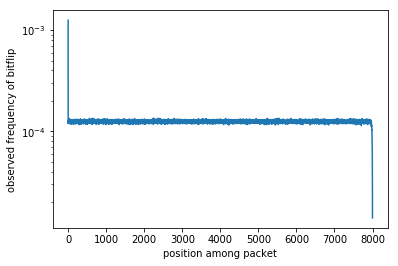

== flipped bit statistics for udp_1kb_wfakeerrors_p0.2_s-1.0 ==
total packets: 16149
total bits: 129192000
total flipped bits: 25838682  (20.00%)
position of flipped bits:


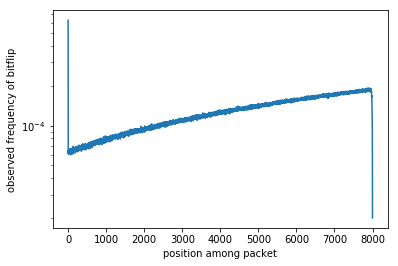

== flipped bit statistics for udp_1kb_wfakeerrors_p0.2_s1.0 ==
total packets: 16346
total bits: 130768000
total flipped bits: 26155730  (20.00%)
position of flipped bits:


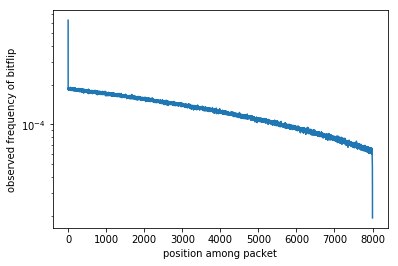

== flipped bit statistics for udp_1kb_wfakeerrors_p0.2_s-2.0 ==
total packets: 16378
total bits: 131024000
total flipped bits: 26206790  (20.00%)
position of flipped bits:


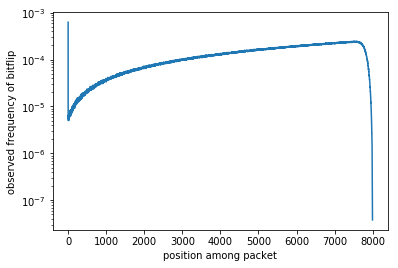

== flipped bit statistics for udp_1kb_wfakeerrors_p0.2_s2.0 ==
total packets: 16324
total bits: 130592000
total flipped bits: 26120312  (20.00%)
position of flipped bits:


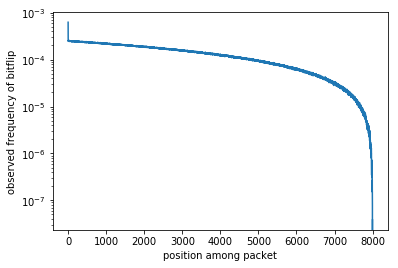

In [11]:
for df in captures: 
    plot_posb1(df)
    plt.show()

In [29]:
try: 
    pkt
except NameError: 
    cap = pyshark.FileCapture('../captures/udp_1kb_wfakeerrors_p0.1.pcap', display_filter=flt)
    limit = 0 # 0=no limit
    pkt = next(iter(cap))
    
print(dir(pkt))

def type_len(obj):
    if hasattr(obj, 'len'):
        return "type: {}, len: {}".format(type(obj), len(obj))
    else:
        return "type: {}".format(type(obj))
    
print("pkt.data.len = %d" % int(pkt.data.len))
print("")

print("pkt.data.data -- ", type_len(pkt.data.data))
print(pkt.data.data[:100], '...')
print("is str instance: %s" % isinstance(pkt.data.data,str))
print("attributes that str does not have: %s" % (set(dir(pkt.data.data))-set(dir(str))))
print("")

print("pkt.data.data.raw_value --", type_len(pkt.data.data.raw_value))
print(pkt.data.data.raw_value[:100], '...')
print("")

print("pkt.data.data.hex_value --", type_len(pkt.data.data.hex_value))
print(pkt.data.data.hex_value)
print("")

print("pkt.data.data.binary_value --", type_len(pkt.data.data.binary_value))
print(pkt.data.data.binary_value)
print("")

#print("with 0/1: %s" % bin(pkt.data.data.hex_value))
countb1 = bin(pkt.data.data.hex_value).count("1")
print("number of ones (non-zero bits): {} ({:.2%})".format(countb1, countb1/(int(pkt.data.len)*8)))
#print(pkt.data.data)
#print("position of ones: ", getposb1(pkt.data.data.hex_value))

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_packet_string', 'captured_length', 'data', 'eth', 'frame_info', 'get_multiple_layers', 'highest_layer', 'interface_captured', 'ip', 'layers', 'length', 'number', 'pretty_print', 'sniff_time', 'sniff_timestamp', 'transport_layer', 'udp']
pkt.data.len = 1000

pkt.data.data --  type: <class 'pyshark.packet.fields.LayerFieldsContainer'>
00c000c000000404800000002200080218080002090200c048000020000000080000000a6000100021400288000808200008 ...
is str instance: True
attributes that str does not have: {'all_fields', '__getattr__', 'alternate_fields', 'add_field', '__dict__', 'fi